# Significance Tests

In this tutorial I'm going to introduce a way of measuring differences between two groups in cases where your data represents only a "sample" of the whole population, or when you only have data for a short time period. You want to know whether the difference you've measured for the data you have is going to hold true in the future - whether the "sample" reflects the whole population. In statistics, this type of analysis is called "significance testing", because it tests whether the result you have measured is "statistically significant" - i.e. whether we should trust it or not.

The approach I'm going to demonstrate is slightly different than the strict statistical tests you might have heard of - "chi squared tests" and "t-tests" for example. I use a technique that is sometimes described as "Baysian" - instead of using a complex mathematical formula, I lean on the power of computers to perform calculations very quickly. I "simulate" running an experiment many times in order to get an understanding of the range of likely results.

More important than this difference of implementation though is a difference of interpretation. Rather than a "pass/fail" threshold that you might see with some statistical tests, I use a more nuanced approach that focuses on trying to understand the likely range of the difference between to groups.

Lets get into it.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare

from create_data import binomial_df1, binomial_df2, exponential_df, normal_df
import matplotlib.pyplot as plt
%matplotlib inline

## Part One: Binomial Data

You've been running an experiment - a classic A/B test. Users come to your site, and get assigned to a "test" or "control" group, which determines what they see on the site. The users then either "convert" (sign up for your product) or they don't. Your data set records every visit to your site, whether the user was assigned to test or control, and whether that user converted.

Your experiment started on the 6th of Feb, 2020, and it's been running for a week.

Here's what that dataset looks like:

In [21]:
trial_end_date = "2020-02-13"
df = binomial_df1.loc[:trial_end_date]
df.head()

,converted,label
2020-02-06,0,control
2020-02-06,0,control
2020-02-06,1,control
2020-02-06,1,test
2020-02-06,1,control


Since it's been a week, let's check in and see how our experiment is going. Now, strictly speaking this is bad experiment design - what we _should_ have done is figured out how much data we need in order to get a confident result, and waited until we had that much data. In practice though, I've found you very rarely have all the information you need in order to make those determinations. Usually, it's very useful to be able to do this after the fact.

Because this data is very nicely set up already (unlike what you'll find in real life), it's easy to calculate the conversion rate for our test and control groups.

In [26]:
(
df
    .groupby('label')
    ['converted']
    .agg(['mean', 'count'])
)

,mean,count
label,,
control,0.538710,310
test,0.536585,82


Looks like there's no difference between the test and control groups! Probably time to shut down the experiment and try something different, right?

But hold on! There's only been about 400 visitors in the last week! Maybe we don't have enough information to make a decision yet. Should we wait longer, potentially wasting time, or should we cut our losses now?

We need some way of knowing how likely it is that the outcome could change if we had more data. How do we do that? 

There's a trick we can use.

If there is no difference between our new design and the old one, then it shouldn't matter what values we have in the `label` column in our DataFrame, right? If test and control are getting exactly the same outcomes, we should be able to assign those values randomly, and see roughly the same difference between the test and control groups. In other words, if the value in the `label` column truly has no impact on the conversion rate, then there should be no difference between the observed conversion rates from our data, and the conversion rates of two groups that are assigned randomly.

Let's test that.

In [31]:
def random_difference(df: pd.DataFrame) -> float:
    """Randomly assigns rows in a DataFrame to 'test' or 'control' based on proportions found in the 'label' column, and compares means found in the 'converted' column"""
    p = (df['label'] == 'test').sum()/len(df)
    idx = np.random.binomial(1, p, len(df)) == 1
    return df['converted'].loc[idx].mean() - df['converted'].loc[~idx].mean()

The method above will calculate the difference in conversion rates for randomly-generated test and control groups. Because these are randomly generated groups, the difference we see is sometimes big, and sometimes small. Let's run it a few times and see what kind of values we get.

In [36]:
for _ in range(10):
    print(round(random_difference(df), 2))

0.04
0.06
-0.06
0.04
-0.12
-0.04
0.06
-0.02
0.03
0.01


You can see that we get quite a range of results - in other words, sometimes the randomly-generated difference is the same as our observed difference (i.e. zero, what we'd expect if there were truly no difference between the test and control group), but sometimes the randomly-generated groups have quite a big difference. What does that mean?

Let's generate more of these random differences. If we plot them, we see something quite interesting.

In [41]:
differences = []
observed = (df.loc[df['label'] == 'test'].mean() - df.loc[df['label'] == 'control'].mean())[0]
for _ in range(1000):
    differences.append(observed - random_difference(df))
differences = pd.Series(differences)

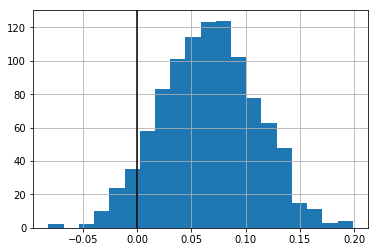

In [46]:
differences.hist(bins=20)
plt.axvline(0, c='k')
plt.show()

Look at that! There's a nice "normal" (or bell-shaped) distribution of values around zero. In other words, as we'd expect, if there is no difference between the new design and old, we'd expect to usually measure zero difference between the test and control groups, just like we saw in the observed data.

But look at the _spread_ of the values! Sometimes we see as much as +/-15% difference! In other words, even if there were no difference between the new and old designs, given the amount of data we have and the baseline conversion rate, we would still expect to sometimes see as much as 15% difference between the two groups, entirely by chance.

What do we do with that information? What does this mean for our A/B test? Should we keep the test running, or end it now?

It depends. We know two things: 

One, the _most likely_ value for the true difference between the new design and the old one is 0%. The observed difference in our data between test and control is always most likely to be the true difference. 

Two, we know that the true difference _could be_ as high as +15% or as low as -15%. It's _quite likely_ to be as high as +5%-10%, or as low as -5%-10%. 

We can quantify that more accurately by giving the percentile values for the differences we generated.

In [51]:

for ntile in [0.05, 0.25, 0.75, 0.95]:
    print(ntile, round(differences.quantile(ntile), 2))

0.05 -0.01
0.25 0.04
0.75 0.1
0.95 0.14


This shows that the true difference is about 50% likely to be in the range of -4% to +4%, and about 90% likely to be in the range -10% to +10%.

What do we do with this information?

We can be reasonably certain that the true difference between the new design and the old is between -10% and +10%. If we only care about rolling out these changes if the new design is substantially better (say, +20%) than the old one, then we probably don't need to run our test for any longer. It's quite unlikely (10% chance) that more data will uncover that the true difference is more than 10% in either direction. But let's say we want to roll out the new design so long as it's _not worse_ than the old design. In this case, we need more information. It's most likely that the new design has exactly the same conversion rate as the old one, but it's very possible that its conversion rate is actually substantially worse. To rule this out, we need more data.

Let's re-run the previous analysis, but with a dataframe containing two weeks of data.

In [101]:
trial_end_date = "2020-02-20"
df2 = binomial_df1.loc[:trial_end_date]
(
df2
    .groupby('label')
    ['converted']
    .agg(['mean', 'count'])
)

,mean,count
label,,
control,0.502591,579
test,0.568862,167


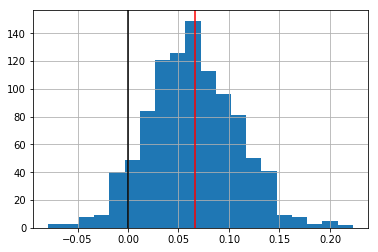

In [58]:
differences = []
observed = (df2.loc[df2['label'] == 'test'].mean() - df2.loc[df2['label'] == 'control'].mean())[0]
for _ in range(1000):
    differences.append(observed - random_difference(df2))
differences = pd.Series(differences)

differences.hist(bins=20)
plt.axvline(0, c='k')
plt.axvline(observed, c='r')
plt.show()

Fascinating! Looks like the early data was a little misleading!  With the addition of some more data, the test group did better than the control group, and the new best estimate for the difference between the new design and the old is now around 6-7 percentage points. I've added a red line to the chart to show the observed difference between the real test and control groups, and then the blue area shows the difference between that value and the randomly-generated test and control groups. You can interpret the blue area as showing the possible range of values for the difference between the new design and the old. 

Let's look at that in more detail, by checking out the interquartile ranges of the random differences we generated.

In [59]:
for ntile in [0.05, 0.25, 0.75, 0.95]:
    print(ntile, round(differences.quantile(ntile), 2))

0.05 -0.01
0.25 0.03
0.75 0.1
0.95 0.14


We see that 50% of our differences are between 4% and 10% - in other words, we can be 50% certain that the true difference is between 4% and 10%. Notice how not only is the mid-point higher than before (i.e. the average has shifted upwards), but also the _size of the range_ has shrunk. Because we have more data in our sample, the differences generated by our random shuffling method are more consistent. The more data we have, the narrower the spread we see in the range of differences, and consequently, the more confident we can be about the true difference between the new design and the old one.

Looking at those interquartile values, we can see that 95% of the randomly-generated differences were greater than zero. That means that we can be about 95% confident that the new design is at least no worse than the old design. It's _most likely_ that the new design is between 4% and 10% better.

### Problems

* With two months of data, what is the best estimate for the true value of the difference between the new deign and the old design?
* How many weeks of data do we need before we can be 95% certain that the new design is at least 5% better than the old design?
* *HARD MODE* There's another DataFrame, called `binomial_df2`, which has similar data, except it has data for _three_ different designs. Figure out how to apply the above techniques to this data set. Hint: You'll need to modify the `random_difference` function I wrote above.

## Part Two: Exponential Data

Previously, the data we looked at was "binomial", that is, the column we were interested in, `converted`, contained only zeroes and ones. There's another kind of data that's very common in A/B testing, which is "exponential" data. That's where you have values that are _usually_ low (or zero), but they _could be_ very high, and there's no real limit to how high they might be. We often see this kind of data when we count how often somebody does a thing, how many dollars someone spends, or how much of something someone uses.

I've made a DataFrame, `exponential_df` that contains this kind of data. It represents an A/B test where a new design is rolled out that is expected to increase the amount of money users spend. Like the previous DataFrame, it has a date index and a label column, but this time instead of looking at whether the user converted, we're looking at how many dollars the user spent.

In [2]:
exponential_df.head(10)

,dollars,label
2020-02-06,4.20,control
2020-02-06,0.00,control
2020-02-06,29.83,control
2020-02-06,2.51,control
2020-02-06,5.52,control
2020-02-06,1.81,control
2020-02-06,32.44,control
2020-02-06,37.19,control
2020-02-06,3.16,test
2020-02-06,37.20,control


If we plot the `dollars` column, we can see the characteristic ditribution of exponential data.

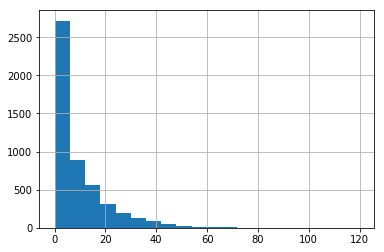

In [3]:
exponential_df['dollars'].hist(bins=20)
plt.show()

Lets imagine we've got a week of data from our experiment. How do we apply the technique we used with the binomial data above, to this exponential data?

In [125]:
trial_end_date = "2020-02-13"
df = exponential_df.loc[:trial_end_date]
(
df
    .groupby('label')
    ['dollars']
    .agg(['mean', 'count'])
)

,mean,count
label,,
control,10.099257,350
test,7.780238,42


Let's re-write our `random_difference` method a little, to make it more generic. I'm also going to roll up the multiple iterations into the method, so that it returns a thousand randome differences rather than just one. This makes the method a bit harder to read, but it allows us to make it much more efficient. I'm calling the new method `random_differences`.

In [130]:
def random_differences(test_values: pd.Series, control_values: pd.Series, n_iterations=1000) -> pd.Series:
    """Given a set of test and control values, calculate random differences between test and control with similar proportions in each group."""
    n_values = len(test_values) + len(control_values)
    p = len(test_values)/n_values
    ns = [i % n_iterations for i in range(n_values * n_iterations)] # create indexes for n_iterations groups
    idx = np.random.binomial(1, p, n_values * n_iterations) == 1 # create index to randomly assign values to test and control
    df = (
            pd.concat([test_values, control_values] * n_iterations) # repeat test and control values n_iterations times
                .groupby([ns, idx]) # group for each iteration, and then our random test and control groups
                .mean() # take average of test and control for each iteration
                .unstack() # align test and control into seperate series
    )
    return df[True] - df[False] # return difference between test and control for each iteration

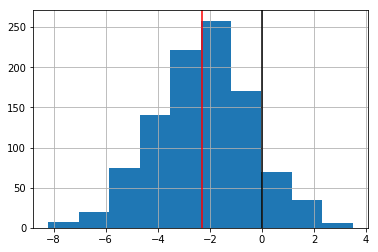

In [132]:
test = df.loc[df['label'] == 'test']['dollars']
control = df.loc[df['label'] == 'control']['dollars']

observed = test.mean() - control.mean()
differences = random_differences(test, control)

(observed - differences).hist()
plt.axvline(0, c='k')
plt.axvline(observed, c='r')
plt.show()

In [134]:
for ntile in [0.05, 0.25, 0.75, 0.95]:
    print(ntile, round((observed - differences).quantile(ntile), 2))

0.05 -5.32
0.25 -3.5
0.75 -1.05
0.95 0.86


Everything works more or less the same! One consequence of exponential data though is that you'll tend to get much wider distributions of values - since you can have very large numbers in the data, it's easy for the randomly-generated differences to skew one way or the other. In this case, our best estimate is that the new design is actually _worse_ than the old design - users spend on average just over two dollars less. There's a substantial amount of uncertainty though. There's a 50% chance that the true difference is between -$3.50 and -$1.05. There's a small chance that the new design is actually no different or slightly better than the old design.

### Problems

* For the above analysis, exactly how likely is it that the new design is no different or better than the old design?
* How long do you need to run the experiment to be ~95% certain that the new design is not better than the old design?
* HARD MODE: There's another DataFrame `normal_df`, which contains normally-distributed data. With two weeks of data from that DataFrame, what is the best estimate of the difference between test and control? Would you recommend rolling out the new design?